In [147]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import math
from typing import Literal
from scipy.stats import pearsonr

In [148]:
# 数据集路径及文件名
file_path = './dataset/'
file_name_A = 'cityA_groundtruthdata.csv.gz'
file_name_B = 'cityB_challengedata.csv.gz'
file_name_C = 'cityC_challengedata.csv.gz'
file_name_D = 'cityD_challengedata.csv.gz'

In [149]:
# 读取数据集并转换为numpy数组格式
traj_A = pd.read_csv(file_path + file_name_A, compression='gzip').to_numpy()
traj_B = pd.read_csv(file_path + file_name_B, compression='gzip').to_numpy()
traj_C = pd.read_csv(file_path + file_name_C, compression='gzip').to_numpy()
traj_D = pd.read_csv(file_path + file_name_D, compression='gzip').to_numpy()

# Functions

## Process

In [150]:
# 函数：欧式距离
def Euclidean_Distance(point1, point2):
    """
    计算二维空间中两个点之间的欧式距离。
    
    参数
    point1 (tuple): 第一个点的坐标，格式为 (x1, y1);
    point2 (tuple): 第二个点的坐标，格式为 (x2, y2)
    
    返回值:
    float: 两个点之间的欧式距离
    """
    x1, y1 = point1
    x2, y2 = point2
    distance = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    return distance

In [151]:
# 函数：剔除不需要的数据点
def mask_to_predict(ref_arr, *arrs, rm_days=False, reverse=False):
    """
    rm_days = True  时剔除61-75天的数据点，ref_list应为day的numpy数组
    rm_days = False 时剔除待预测的数据点，ref_list应为x或y的numpy数组
    返回所有需要剔除的数组，包括ref_list
    """
    # 剔除条件
    if rm_days is True:
        mask = ref_arr < 60
    else:
        mask = ref_arr <= 200
    # 翻转
    if reverse is True:
        mask = ~mask
    # 初始化
    masked_arrs = []
    # 剔除
    masked_ref_list = ref_arr[mask]
    masked_arrs.append(masked_ref_list)
    for arr in arrs:
        masked_arr = arr[mask]
        masked_arrs.append(masked_arr)
    
    return masked_arrs

## Calculate

In [152]:
# 函数：计算城市中每用户的总距离或总签到次数
def dis_peruser(traj, rm_days=False, is_counts=False):
    """
    计算城市中每用户的总距离：
    参数: numpy数组(uid, day, timeslot, x, y),rm_days=Ture时表示剔除61-75天的数据
    返回: numpy数组(distance)
    """
    
    # 提取所需数据
    uids, days, x_values, y_values = traj[:, 0], traj[:, 1], traj[:, 3], traj[:, 4]

    # 剔除待预测点
    if rm_days is False:
        x_values, y_values, uids = mask_to_predict(x_values, y_values, uids)
    else:
        days, x_values, y_values, uids = mask_to_predict(days, x_values, y_values, uids, rm_days=rm_days)

    # 初始化
    max_uids = int(np.max(uids)) + 1
    dis_per_user = np.zeros(max_uids)
    dis = 0

     # 按用户统计距离
    for i in range(len(x_values)):
        if (i != 0) and (uids[i] != uids[i-1]):
            dis_per_user[uids[i-1]] = dis
            dis = 0
            continue
        if is_counts is True:
            dis += 1
        else:
            dis += Euclidean_Distance((x_values[i], y_values[i]),(x_values[i-1], y_values[i-1]))
    
    return dis_per_user

In [153]:
# 函数：计算城市内每用户每天的总距离
def dis_peruser_perday(traj, rm_days=False): 
    """
    计算每个用户每天的轨迹总距离
    输入：numpy数组(uid, day, timeslot, x, y)
    输出：numpy数组(distance), size=(#user, #day)
    """
    # 提取数据
    uids, days, x_values, y_values = traj[:, 0], traj[:, 1], traj[:, 3], traj[:, 4]

    # 剔除待预测点
    if rm_days is False:
        x_values, uids, days, y_values = mask_to_predict(x_values, uids, days, y_values)
    else:
        days, uids, x_values, y_values = mask_to_predict(days, uids, x_values, y_values, rm_days=True)

    # 初始化
    num_users = np.max(uids) + 1
    num_days = np.max(days) + 1
    dis_pp = np.zeros((num_users, num_days))
    dis = 0
    # 统计每个用户每天的平均距离
    for i in range(len(x_values)):
        if (days[i] != days[i-1]) or (uids[i] != uids[i-1]):
            if i != 0:
                dis_pp[uids[i-1], days[i-1]] = dis
            dis = 0
            continue
        dis += Euclidean_Distance((x_values[i], y_values[i]),(x_values[i-1], y_values[i-1]))
    
    return dis_pp.flatten()

In [154]:
# 函数：计算城市内用户数据活跃度的时序序列
def UADCH(traj, only_to_pred=False, only_not_pred=False):
    """统计城市中用户数据的活跃度的时序序列"""

    # 提取数据
    days, timeslots, x_values = traj[:, 1], traj[:, 2], traj[:, 3]

    # 剔除
    if only_to_pred is True:
        x_values, days, timeslots = mask_to_predict(x_values, days, timeslots, reverse=True)
    elif only_not_pred is True:
        days, timeslots, x_values = mask_to_predict(days, timeslots, x_values, rm_days=True, reverse=True)
        x_values, days, timeslots = mask_to_predict(x_values, days, timeslots)

    # 初始化
    timeslot_count = np.zeros((75, 48)) # 以二维索引存储对应day和timeslot的次数

    # 统计各时间戳上的数据数
    for day, timeslot in zip(days, timeslots):
        timeslot_count[int(day), int(timeslot)] += 1

    flattened_timeslot_count = timeslot_count.flatten() # 展平为一维数组
    return flattened_timeslot_count


In [155]:
# 函数：计算城市内用户移动活跃度的时间序列
def UAMCH(traj, rm_days=True):
    """统计城市中用户移动的活跃度的时序序列"""

    # 提取数据
    uids, days, timeslots, x_values, y_values = traj[:, 0], traj[:, 1], traj[:, 2], traj[:, 3], traj[:, 4]

    # 剔除
    if rm_days is True:
        days, uids, timeslots, x_values, y_values = mask_to_predict( days, uids, timeslots, x_values, y_values, rm_days=rm_days)

    # 初始化
    changed_count = np.zeros((75, 48))

    for i in range(len(x_values)):
        if uids[i] != uids[i-1]:
            continue
        if (x_values[i] == x_values[i-1]) or (y_values[i] == y_values[i-1]):
            continue
        changed_count[days[i], timeslots[i]] += 1

    flattened_timeslot_count = changed_count.flatten()
    return flattened_timeslot_count

## Plot

In [156]:
# 函数：绘制距离分布的柱状图
def switch_title(type, city, total_days):
    title_dict = {
        'pu': 'Distribution of distance per user during ' + str(total_days) + ' days for city ' + city,
        'pp': 'Distribution of distance per user per day for city ' + city,
        'cpu': 'Distribution of counts per user during ' + str(total_days) + ' days for city ' + city
    }
    return title_dict.get(type, "Invalid type!")

def plot_bar_dis(dis_arr, 
                 city: Literal['A','B','C','D'], 
                 type: Literal['pu', 'pp', 'cpu'], 
                 bin_stamp=100, total_days=75, 
                 freq_normalize = True, dis_normalize=False):
    """绘制平均轨迹距离用户数分布的柱状图，频数及距离均归一化"""
    # 柱状图参数
    counts, bins = np.histogram(dis_arr, bins=bin_stamp)
    x_label, y_label = 'Distance', 'Frequency'

    # 计算平均数和中位数
    mean = np.mean(dis_arr)
    median = np.median(dis_arr)
    
    # 归一化
    if freq_normalize is True:  # 频数归一化
        total_counts = np.sum(counts)
        counts = counts / total_counts
        y_label = 'Frequency(normalized, max=' + str(len(dis_arr)) + ')'
    if dis_normalize is True:   # 距离归一化
        total_dis = bins[-1]
        bins[:] = bins[:] / total_dis
        mean, median = mean / total_dis, median / total_dis
        x_label = 'Distance(normalized, max=' + str(total_dis) + ')'

    # 绘制柱状图
    plt.figure()
    plt.bar(bins[:-1], counts, width=np.diff(bins), edgecolor='black', alpha=0.7)

    # 标注平均数
    plt.axvline(mean, color='red', linestyle='--', linewidth=1, label=f'Mean: {mean:.3f}')
    plt.text(mean, plt.ylim()[1] * 0.9, f'Mean: {mean:.3f}', color='red', ha='left', va='center')

    # 标注中位数
    plt.axvline(median, color='green', linestyle='--', linewidth=1, label=f'Median: {median:.3f}')
    plt.text(median, plt.ylim()[1] * 0.8, f'Median: {median:.3f}', color='green', ha='left', va='center')

    # 标题和标签
    plt.title(switch_title(type, city, total_days))
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # 显示图像
    plt.show()

In [157]:
# 函数：绘制时间序列的折线图
def plot_histogram(timeslot_count, 
                   city: Literal['A', 'B', 'C', 'D'],
                   type: Literal['Data', 'Move']):
    """绘制时间轴折线图"""
    # 绘制折线图
    plt.figure(figsize=(80, 5))
    plt.plot(timeslot_count, linestyle='-', color='blue')

    # 设置坐标轴范围
    plt.xlim(0, len(timeslot_count) - 1)  # 使 x 轴范围覆盖整个数据
    plt.ylim(min(timeslot_count), max([max(timeslot_count), 1000]))  # 使 y 轴范围覆盖所有数据点

    # 生成连续的时间序列刻度并设置刻度标签
    x_ticks = np.arange(0, (75 + 1) * 48, 48)  # 每48个timeslot为一天
    x_tick_labels = [f'Day {i}' for i in range(75 + 1)]
    plt.xticks(ticks=x_ticks, labels=x_tick_labels, rotation=30)

    # 标题标签
    plt.title( type + ' Counts Histogram for city ' + city)
    plt.xlabel('Time (#day)')
    plt.ylabel(type + ' Counts')

    # 显示图像
    plt.show()

In [158]:
# 函数：绘制含多时间序列的折线图
def plot_histograms(*arrs, type: Literal['Data', 'Move'], log=False):

    cities = ['A','B','C','D']
    colors = ['red', 'blue', 'green', 'orange']

    plt.figure(figsize=(80, 5))
    for i, arr in enumerate(arrs):
        if log is True:
            arr = np.log1p(arr)
        color = colors[i % len(colors)]
        plt.plot(arr, label=f'City {cities[i]}', color=color)
    
    # 添加图例
    plt.legend()

    # 设置坐标轴范围
    plt.xlim(0, len(arr) - 1)  # 使 x 轴范围覆盖整个数据

    # 生成连续的时间序列刻度并设置刻度标签
    x_ticks = np.arange(0, (75 + 1) * 48, 48)  # 每48个timeslot为一天
    x_tick_labels = [f'Day {i}' for i in range(75 + 1)]
    plt.xticks(ticks=x_ticks, labels=x_tick_labels, rotation=30)
    
    # 标题标签
    plt.title( type + ' Counts Histograms for all cities')
    plt.xlabel('Time (#day)')
    plt.ylabel(type + ' Counts')

    # 显示图表
    plt.show()

In [188]:
# 函数：绘制多个时间序列与参考序列的相关性散点图
def plot_multi_scatter(name_list, ref_arrs, *arrs, 
                       type:Literal['counts', 'distance'] = 'counts'):
    num_arrs = len(arrs)
    plt.figure(figsize=(14, 5 * num_arrs))

    for i, series in enumerate(arrs):
        correlation, _ = pearsonr(ref_arrs, series)

        plt.subplot(num_arrs, 1, i + 1)
        plt.scatter(ref_arrs, series, color='blue', alpha=0.6)
        
        # 添加线性拟合直线
        m, b = np.polyfit(ref_arrs, series, 1)
        plt.plot(ref_arrs, m * ref_arrs + b, color='red', linestyle='--', linewidth=2)

        # 设置标题和轴标签
        plt.title(f'Scatter Plot of Reference between {name_list[0]} and {name_list[i+1]} (Correlation: {correlation:.4f})')
        plt.xlabel(f'{type} for {name_list[0]}')
        plt.ylabel(f'{type} for {name_list[i+1]}')
    
    # 调整子图间距
    plt.tight_layout()
    plt.show()


In [184]:
# 函数：绘制不同粒度的空间分布热力图
def plot_coarse_grained_grid_count(traj,
                                   city: Literal['A', 'B', 'C', 'D'],
                                   grid_sizes = [10, 20, 50],     #热力图粒度列表
                                   log=False):
    """绘制轨道数据集的不同粒度下的空间分布热力图"""

    # 提取空间信息
    x_values = traj[:, 3]
    y_values = traj[:, 4]

    # 剔除待预测点
    x_values, y_values = mask_to_predict(x_values, y_values)

    # 设置子图属性
    fig, axes = plt.subplots(1, len(grid_sizes), figsize=(18, 6))
    
    for i, grid_size in enumerate(grid_sizes):
        # 计算每个网格的边界
        x_bins = np.linspace(np.min(x_values), np.max(x_values), grid_size)
        y_bins = np.linspace(np.min(y_values), np.max(y_values), grid_size)

        # 统计每个网格中的数据点数量
        heatmap, _, _ = np.histogram2d(x_values, y_values, bins=[x_bins, y_bins])
        if log is True:
            heatmap = np.log1p(heatmap)

        # 绘制热力图
        im = axes[i].imshow(heatmap.T, origin='lower', cmap='Blues', interpolation='nearest')

        # 添加标题
        axes[i].set_title(f'Grid Size: {grid_size}x{grid_size} for City ' + city)
        axes[i].set_xlabel('X')
        axes[i].set_ylabel('Y')

        # 添加颜色条
        plt.colorbar(im, ax=axes[i])

    # 调整布局
    plt.tight_layout()
    plt.show()

# Distance Statistics

### Distance/User

In [161]:
# 计算各城市的每用户总距离
# 1-75天
dis_pu_A = dis_peruser(traj_A)
# dis_pu_B = dis_per_user(traj_B)
# dis_pu_C = dis_per_user(traj_C)
# dis_pu_D = dis_per_user(traj_D)

# 1-60天
dis_pu_A_rm = dis_peruser(traj_A, rm_days=True)
dis_pu_B_rm = dis_peruser(traj_B, rm_days=True)
dis_pu_C_rm = dis_peruser(traj_C, rm_days=True)
dis_pu_D_rm = dis_peruser(traj_D, rm_days=True)

[5038.479904877441, 4347.384041324108, 3748.8194450819983, 5733.116299407202]


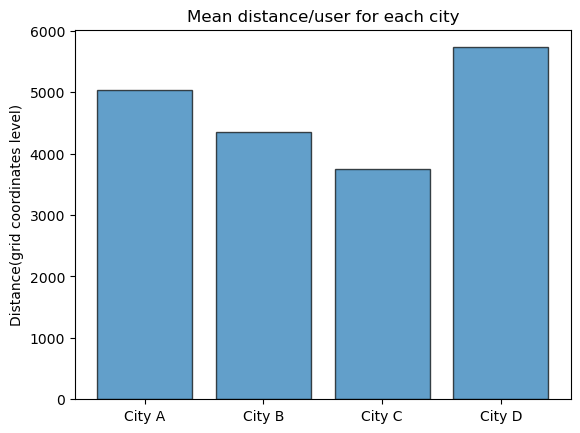

In [162]:
# 计算1-60天各城市平均每用户的总距离并绘制柱状图
A = np.mean(dis_pu_A_rm)
B = np.mean(dis_pu_B_rm)
C = np.mean(dis_pu_C_rm)
D = np.mean(dis_pu_D_rm)

mean_dis_pu = [A, B, C, D]
print(mean_dis_pu)

# 绘制柱状图
x_label = ['City A', 'City B', 'City C', 'City D']
plt.bar(x_label, mean_dis_pu, edgecolor='black', alpha=0.7)
plt.title('Mean distance/user for each city')
plt.ylabel('Distance(grid coordinates level)')
plt.show()

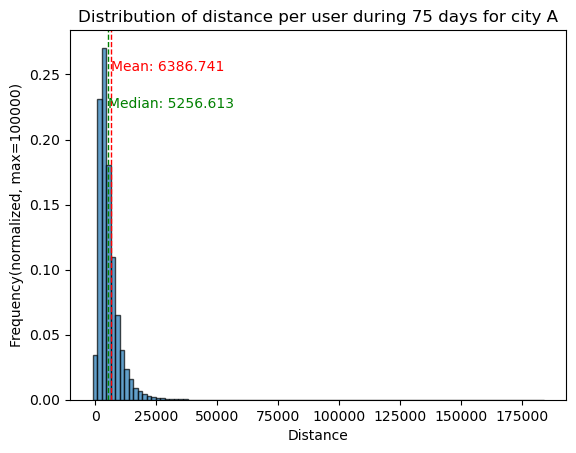

In [163]:
# 绘制1-75天城市A的每用户总距离分布图
plot_bar_dis(dis_pu_A, city='A', type='pu')

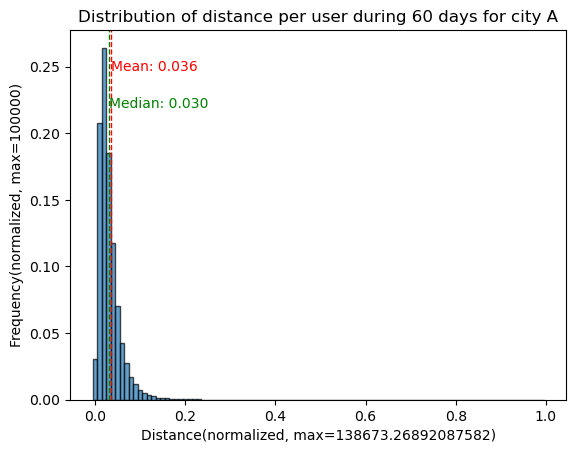

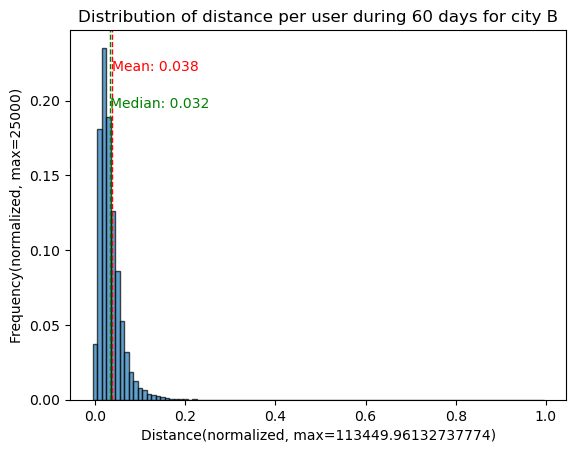

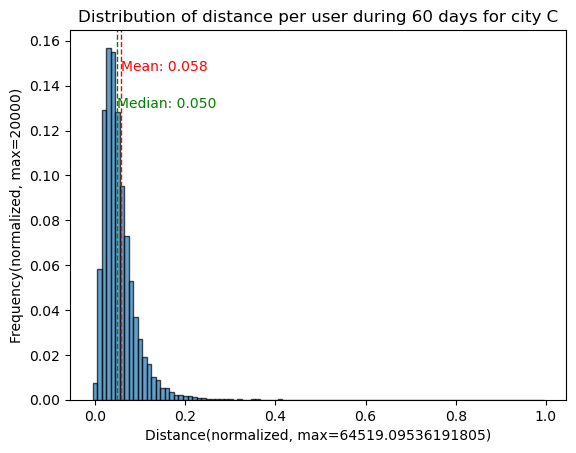

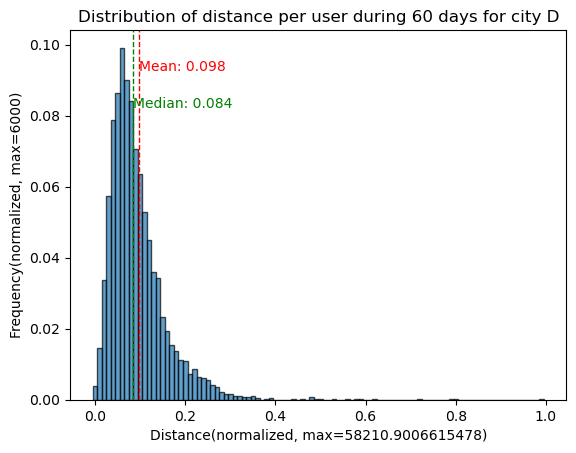

In [164]:
# 绘制1-60天各城市的每用户总距离分布图
plot_bar_dis(dis_pu_A_rm, city='A', type='pu', total_days=60, dis_normalize=True)
plot_bar_dis(dis_pu_B_rm, city='B', type='pu', total_days=60, dis_normalize=True)
plot_bar_dis(dis_pu_C_rm, city='C', type='pu', total_days=60, dis_normalize=True)
plot_bar_dis(dis_pu_D_rm, city='D', type='pu', total_days=60, dis_normalize=True)

### Distance/(Day*User)

In [165]:
# 计算各城市每用户每天的总距离
# 1-75天
dis_pp_A = dis_peruser_perday(traj_A)

# 1-60天
dis_pp_A_rm = dis_peruser_perday(traj_A, rm_days=True)
dis_pp_B_rm = dis_peruser_perday(traj_B, rm_days=True)
dis_pp_C_rm = dis_peruser_perday(traj_C, rm_days=True)
dis_pp_D_rm = dis_peruser_perday(traj_D, rm_days=True)


[79.22589322089435, 67.53821024157855, 57.79775592583671, 90.68616241524767]


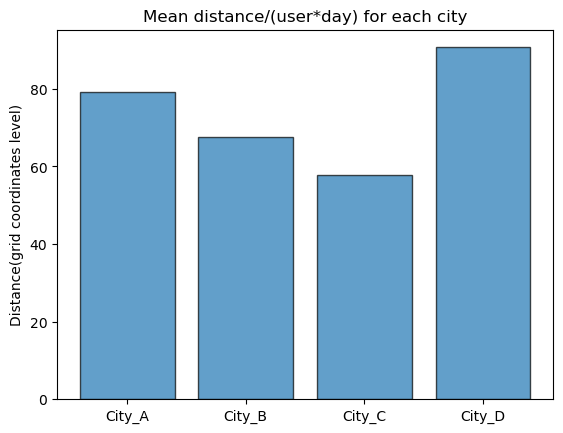

In [166]:
# 计算各城市平均每用户每天的总距离并绘制柱状图
A = np.mean(dis_pp_A_rm)
B = np.mean(dis_pp_B_rm)
C = np.mean(dis_pp_C_rm)
D = np.mean(dis_pp_D_rm)

mean_dis_pp = [A, B, C, D]
print(mean_dis_pp)

# 绘制柱状图
x_label = ['City_A', 'City_B', 'City_C', 'City_D']
plt.bar(x_label, mean_dis_pp, edgecolor='black', alpha=0.7)
plt.title('Mean distance/(user*day) for each city')
plt.ylabel('Distance(grid coordinates level)')
plt.show()

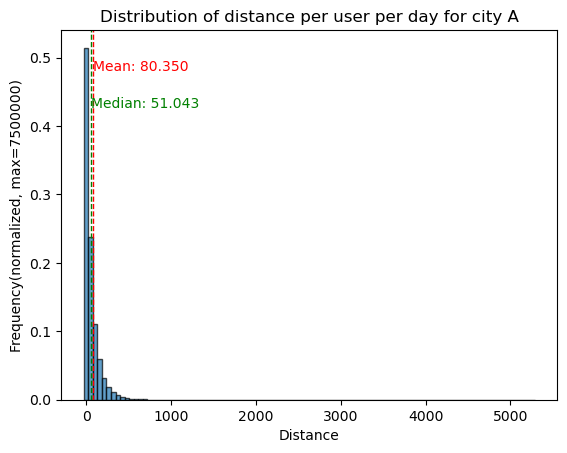

In [167]:
# 绘制1-75天城市A每用户每日总距离分布的柱状图
plot_bar_dis(dis_pp_A, city='A', type='pp')

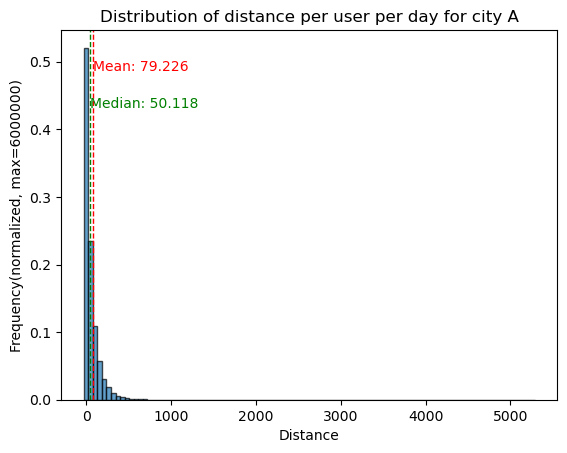

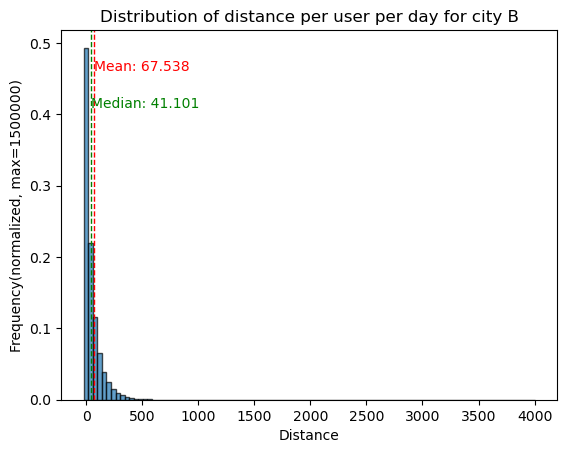

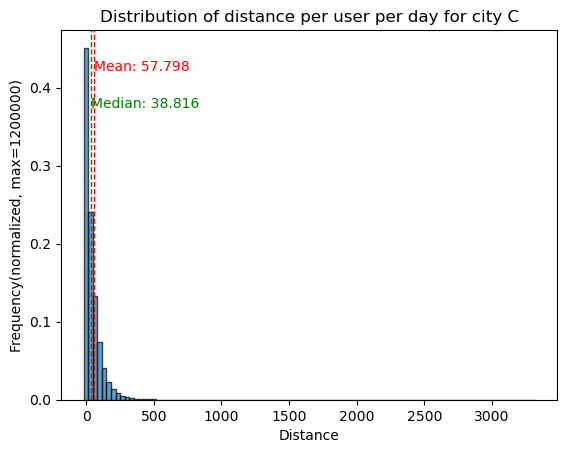

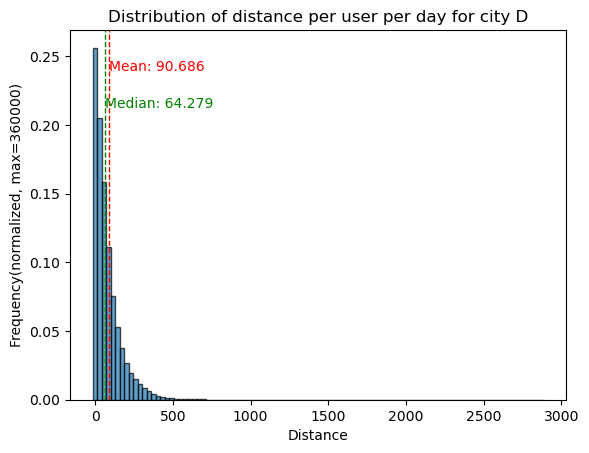

In [168]:
# 绘制1-60天各城市每用户每日总距离分布的柱状图
plot_bar_dis(dis_pp_A_rm, city='A', type='pp')
plot_bar_dis(dis_pp_B_rm, city='B', type='pp')
plot_bar_dis(dis_pp_C_rm, city='C', type='pp')
plot_bar_dis(dis_pp_D_rm, city='D', type='pp')

# Counts Statistics

In [169]:
# 统计各城市每用户的数据数分布
# 1-75天
counts_pu_A = dis_peruser(traj_A, is_counts= True)

# 1-60天
counts_pu_A_rm = dis_peruser(traj_A, rm_days=True, is_counts= True)
counts_pu_B_rm = dis_peruser(traj_B, rm_days=True, is_counts= True)
counts_pu_C_rm = dis_peruser(traj_C, rm_days=True, is_counts= True)
counts_pu_D_rm = dis_peruser(traj_D, rm_days=True, is_counts= True)

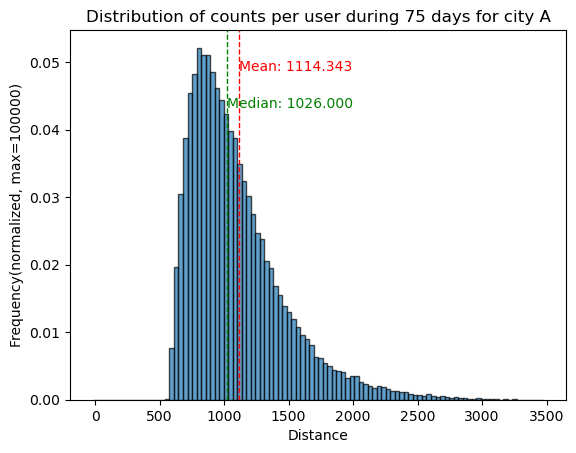

In [170]:
# 绘制城市A每用户数据活跃度的时间序列
plot_bar_dis(counts_pu_A, city='A', type='cpu')

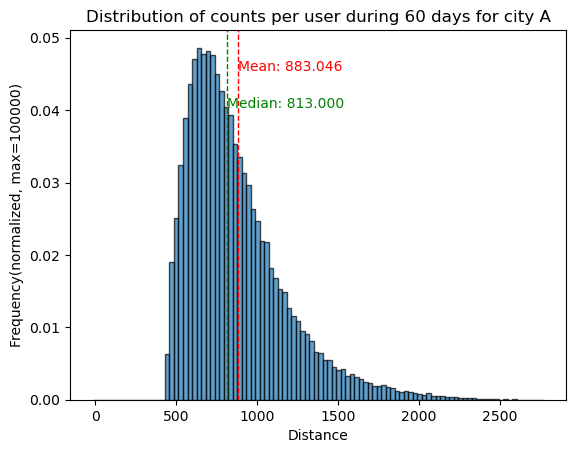

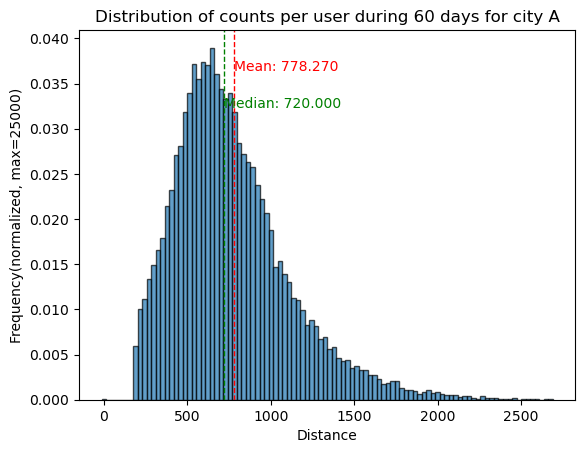

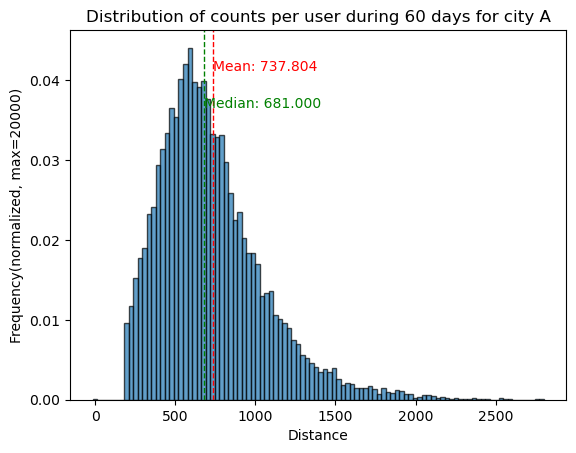

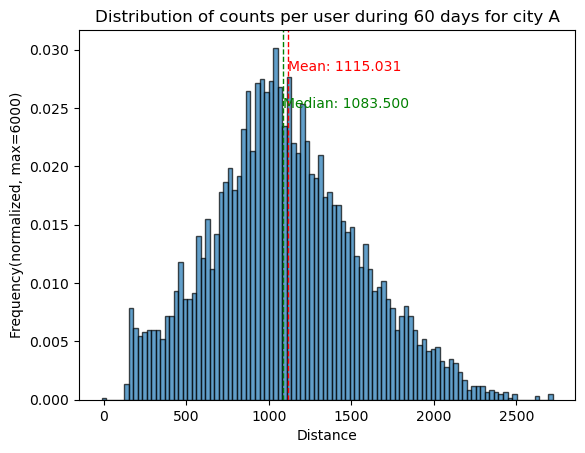

In [171]:
# 绘制各城市每用户的数据数分布（剔除待预测区间）
plot_bar_dis(counts_pu_A_rm, city='A', type='cpu', total_days=60)
plot_bar_dis(counts_pu_B_rm, city='A', type='cpu', total_days=60)
plot_bar_dis(counts_pu_C_rm, city='A', type='cpu', total_days=60)
plot_bar_dis(counts_pu_D_rm, city='A', type='cpu', total_days=60)

# Temporal Statistics

In [172]:
traj_A[:200]

array([[  0,   0,   1,  79,  86],
       [  0,   0,   2,  79,  86],
       [  0,   0,   8,  77,  86],
       [  0,   0,   9,  77,  86],
       [  0,   0,  19,  81,  89],
       [  0,   0,  20,  82,  88],
       [  0,   0,  21,  81,  89],
       [  0,   0,  22,  81,  89],
       [  0,   0,  24,  76,  86],
       [  0,   0,  25,  75,  82],
       [  0,   0,  27,  76,  84],
       [  0,   0,  29,  76,  83],
       [  0,   0,  30,  77,  86],
       [  0,   0,  42,  79, 106],
       [  0,   0,  43,  76,  85],
       [  0,   0,  45,  77,  86],
       [  0,   1,  17,  76,  84],
       [  0,   1,  18,  76,  84],
       [  0,   1,  19,  76,  85],
       [  0,   1,  20,  75,  85],
       [  0,   1,  21,  77,  86],
       [  0,   1,  22,  80,  83],
       [  0,   1,  23,  77,  85],
       [  0,   1,  24,  77,  86],
       [  0,   1,  40,  78,  85],
       [  0,   1,  43,  77,  85],
       [  0,   2,  12,  84,  89],
       [  0,   2,  13,  89,  78],
       [  0,   2,  14, 115,  80],
       [  0,  

 - notes that some consecutive datarow do not reveal a spatial move

## User Activity Data Counts Histogram

In [173]:
# 各城市用户数据活跃度的时序序列
data_count_A = UADCH(traj_A)
data_count_B = UADCH(traj_B)
data_count_C = UADCH(traj_C)
data_count_D = UADCH(traj_D)

# 各城市待预测点的时序序列
data_count_A_p = UADCH(traj_A, only_to_pred=True)
data_count_B_p = UADCH(traj_B, only_to_pred=True)
data_count_C_p = UADCH(traj_C, only_to_pred=True)
data_count_D_p = UADCH(traj_D, only_to_pred=True)

# 各城市待预测区间内非预测点的时序序列
data_count_A_np = UADCH(traj_A, only_not_pred=True)
data_count_B_np = UADCH(traj_B, only_not_pred=True)
data_count_C_np = UADCH(traj_C, only_not_pred=True)
data_count_D_np = UADCH(traj_D, only_not_pred=True)

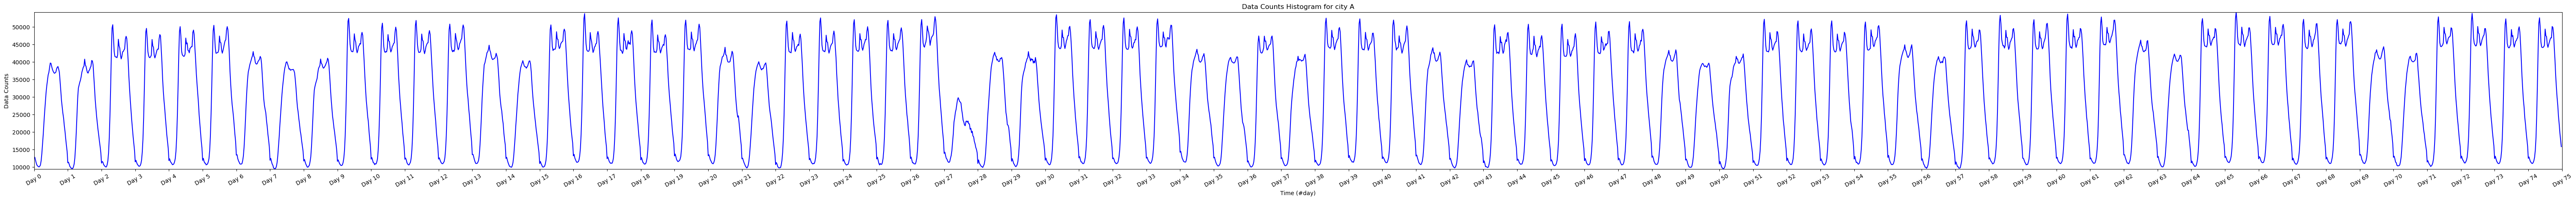

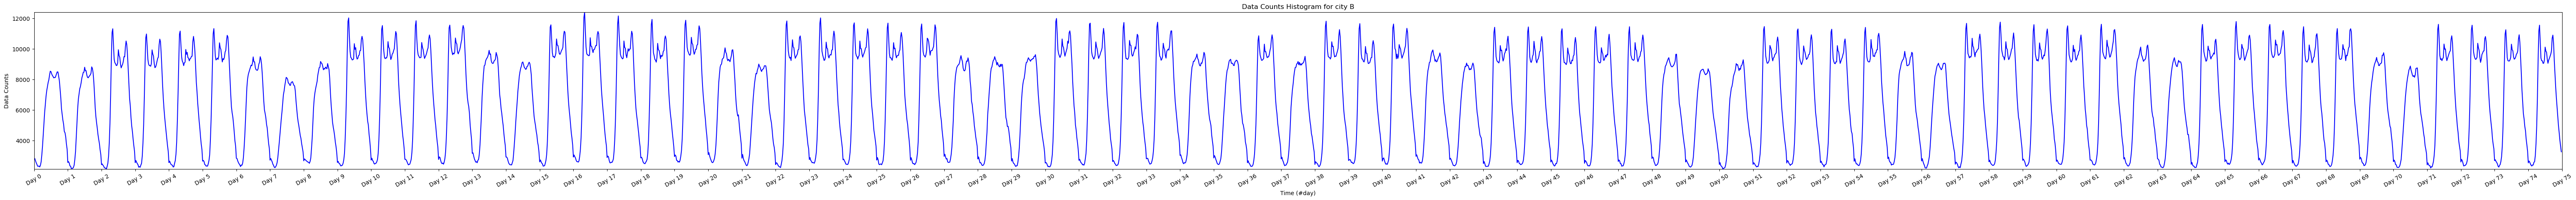

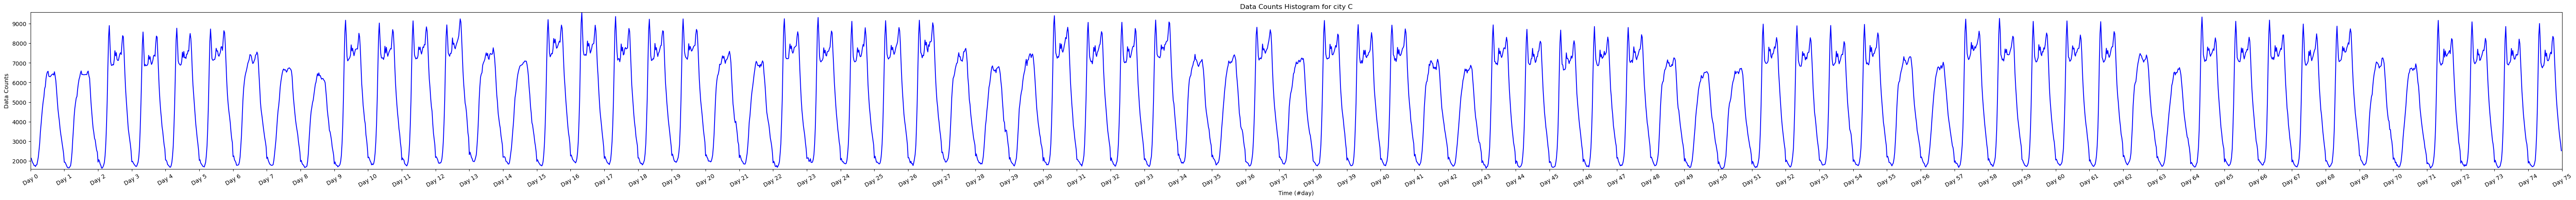

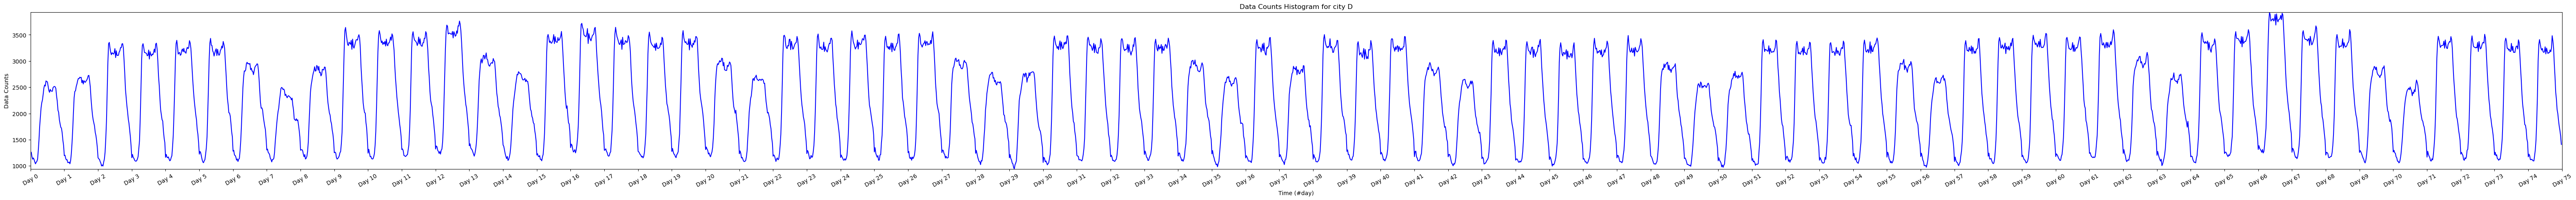

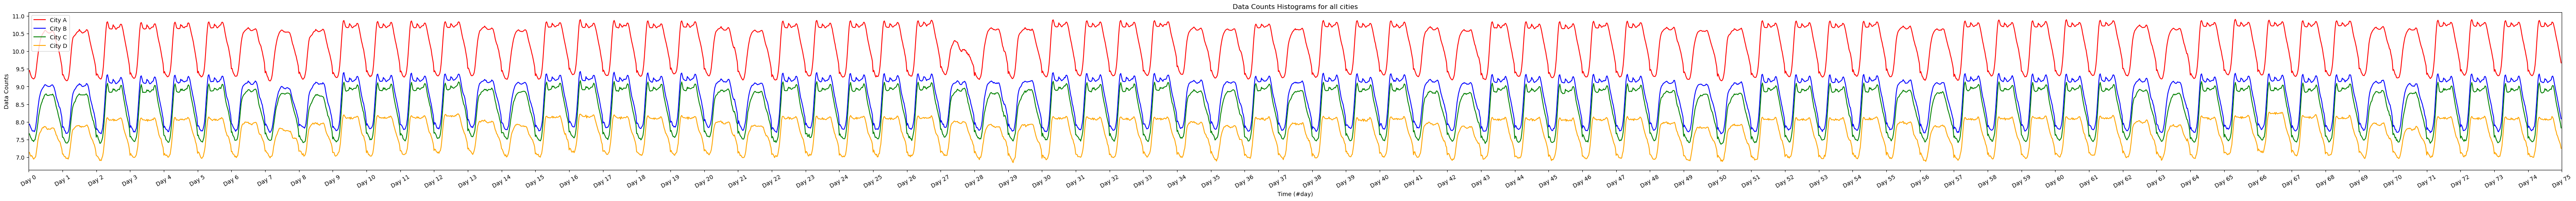

In [174]:
# 绘制各城市用户数据活跃度的时序图
plot_histogram(data_count_A, 'A', 'Data')
plot_histogram(data_count_B, 'B', 'Data')
plot_histogram(data_count_C, 'C', 'Data')
plot_histogram(data_count_D, 'D', 'Data')
plot_histograms(data_count_A, data_count_B, data_count_C, data_count_D, type='Data', log=True)

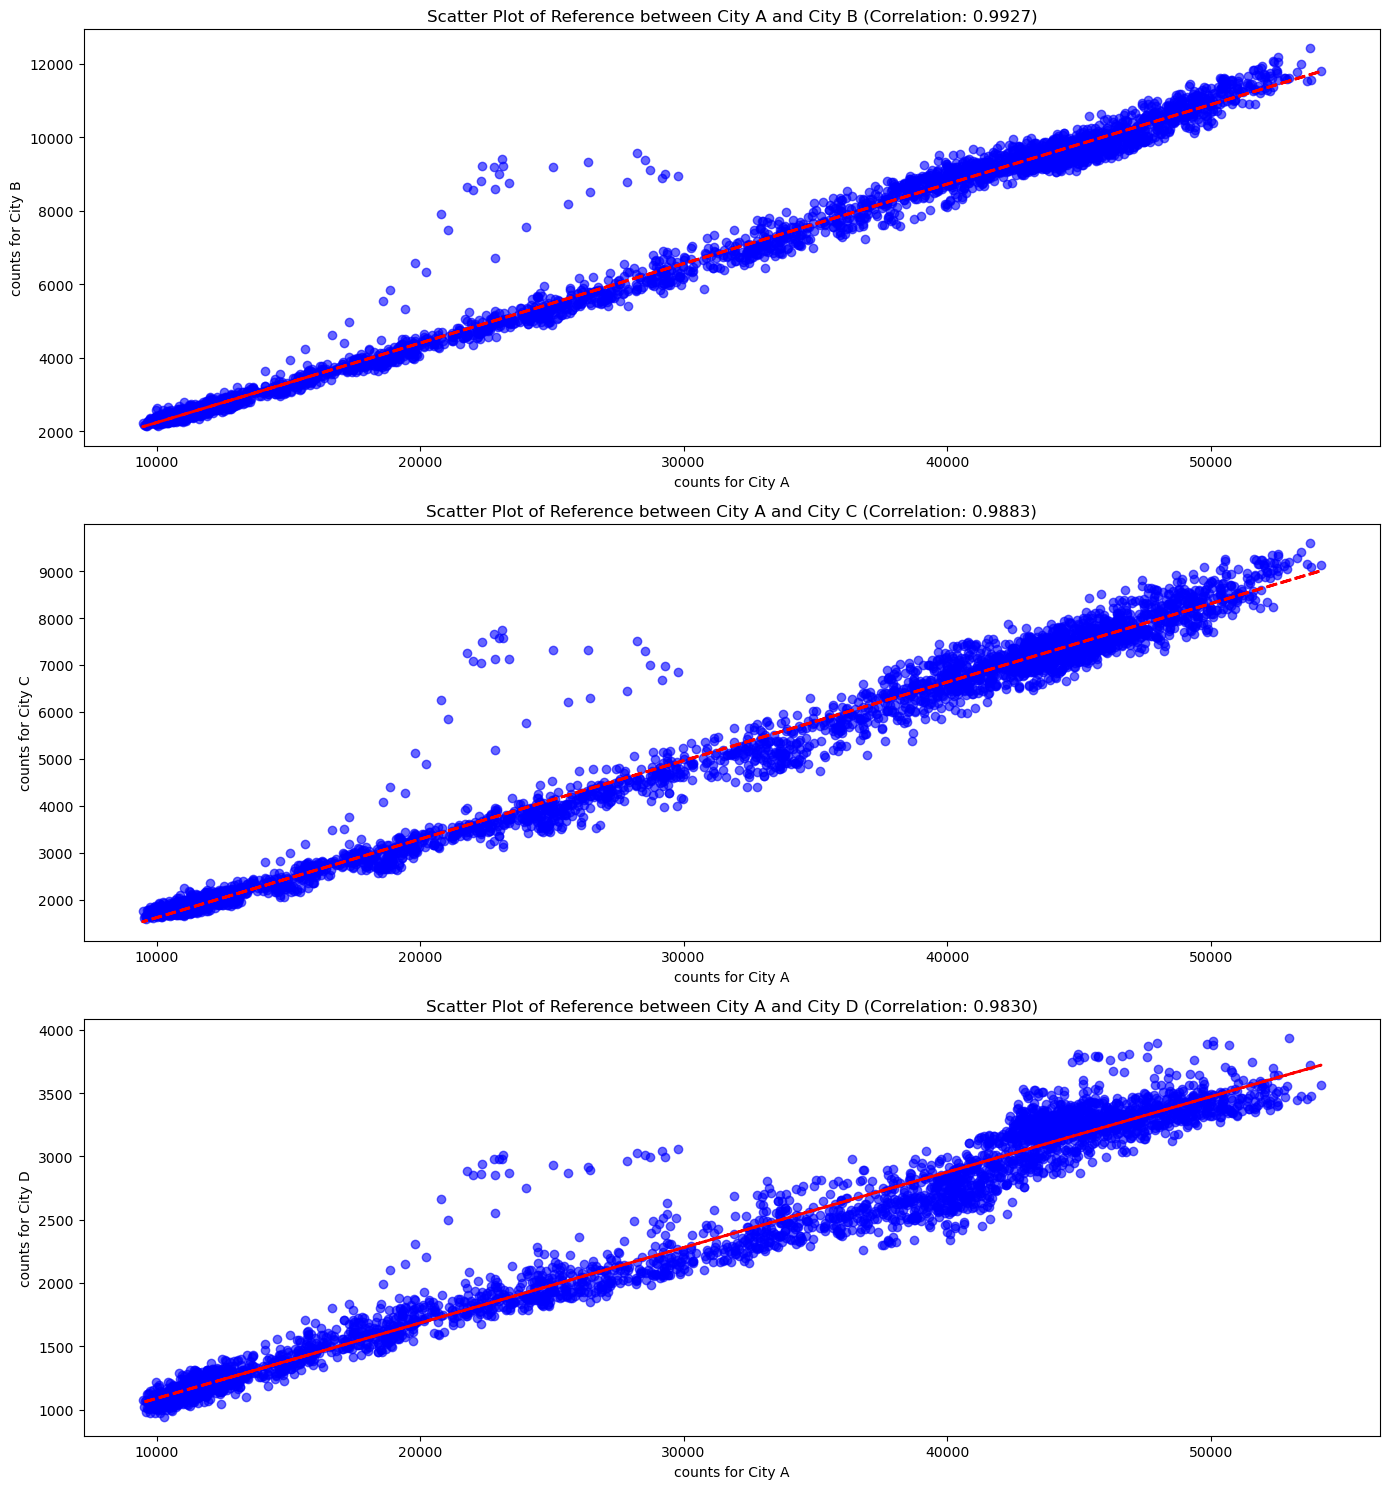

In [175]:
# 相关性分析
plot_multi_scatter(['City A', 'City B', 'City C', 'City D'],data_count_A, data_count_B, data_count_C, data_count_D)

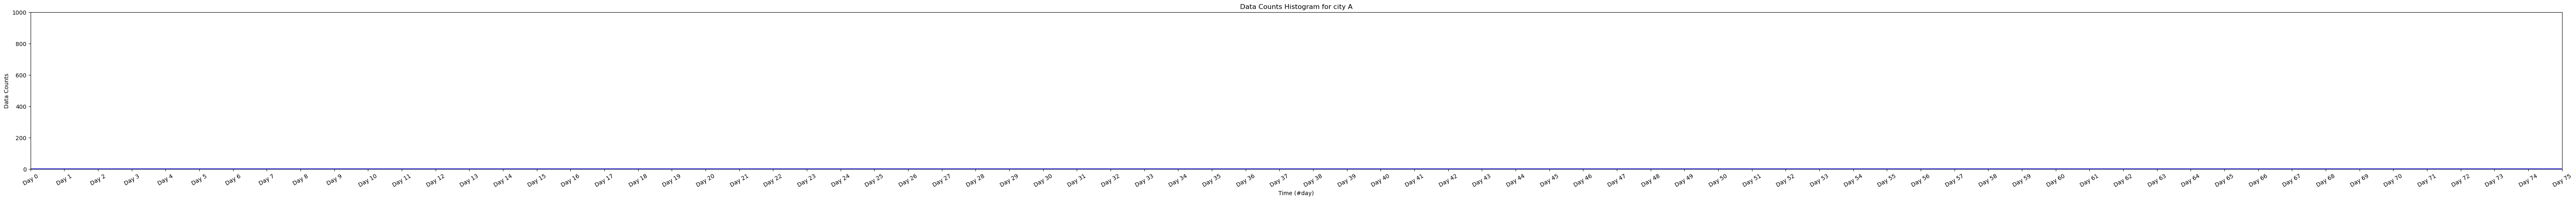

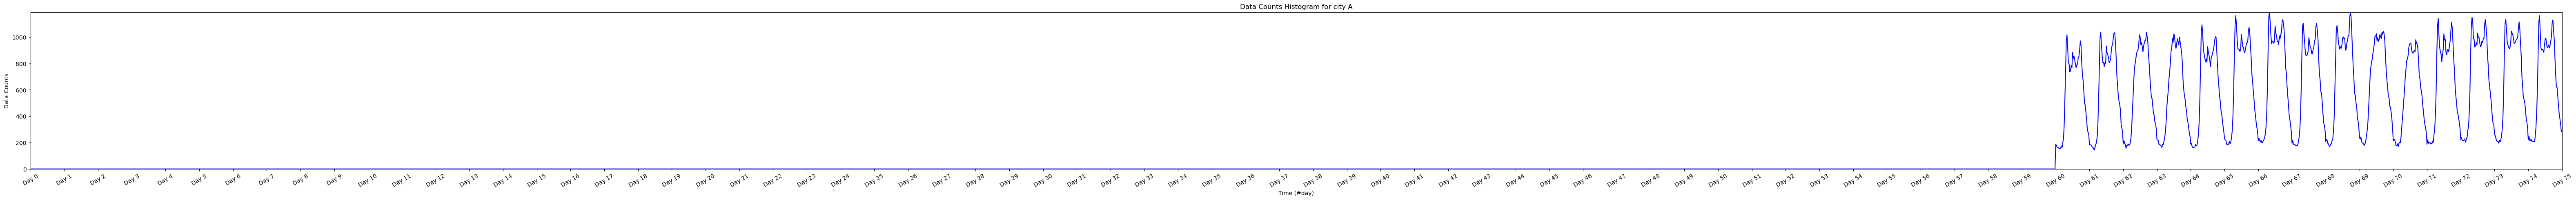

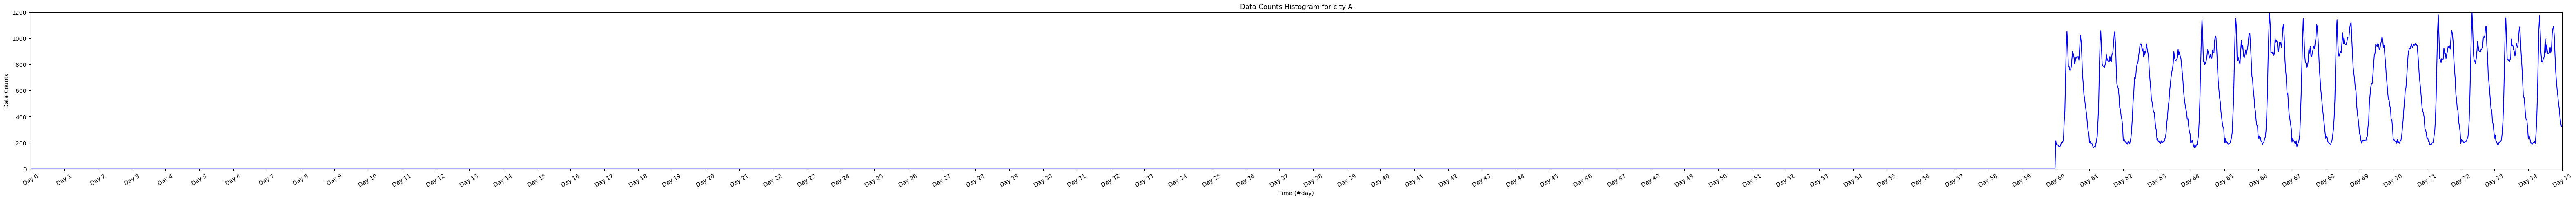

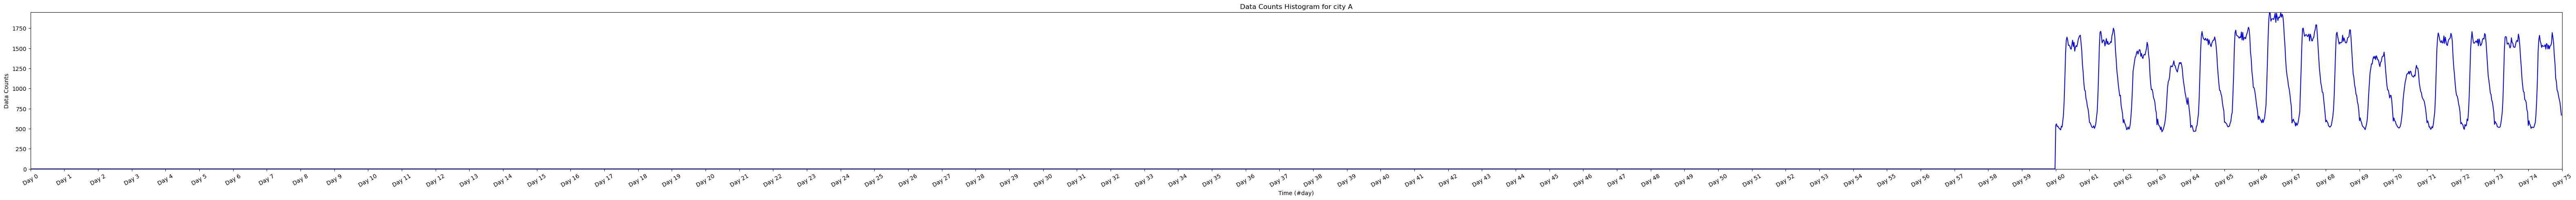

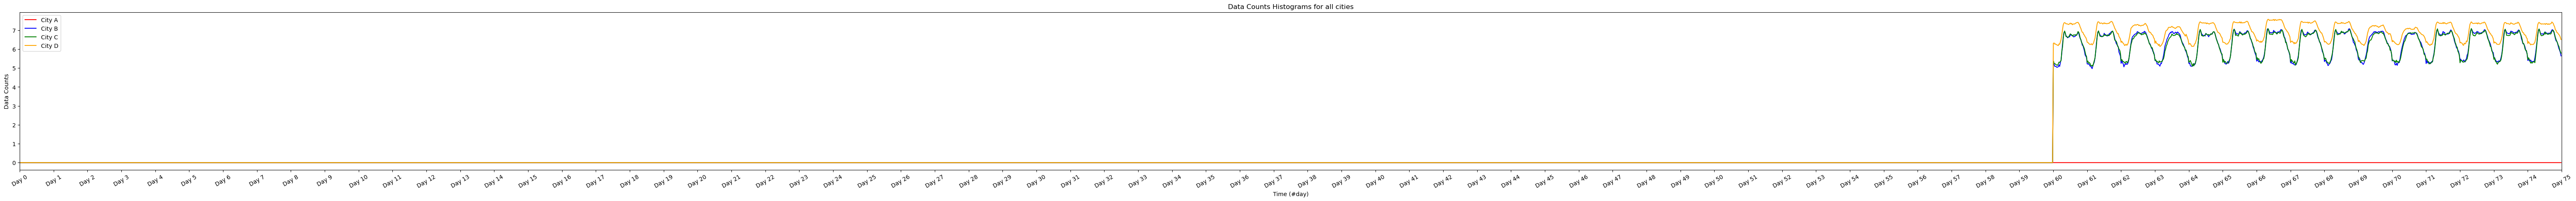

In [176]:
# 绘制待预测点的时序图
plot_histogram(data_count_A_p, 'A', 'Data')
plot_histogram(data_count_B_p, 'A', 'Data')
plot_histogram(data_count_C_p, 'A', 'Data')
plot_histogram(data_count_D_p, 'A', 'Data')
plot_histograms(data_count_A_p, data_count_B_p, data_count_C_p, data_count_D_p, type='Data', log=True)

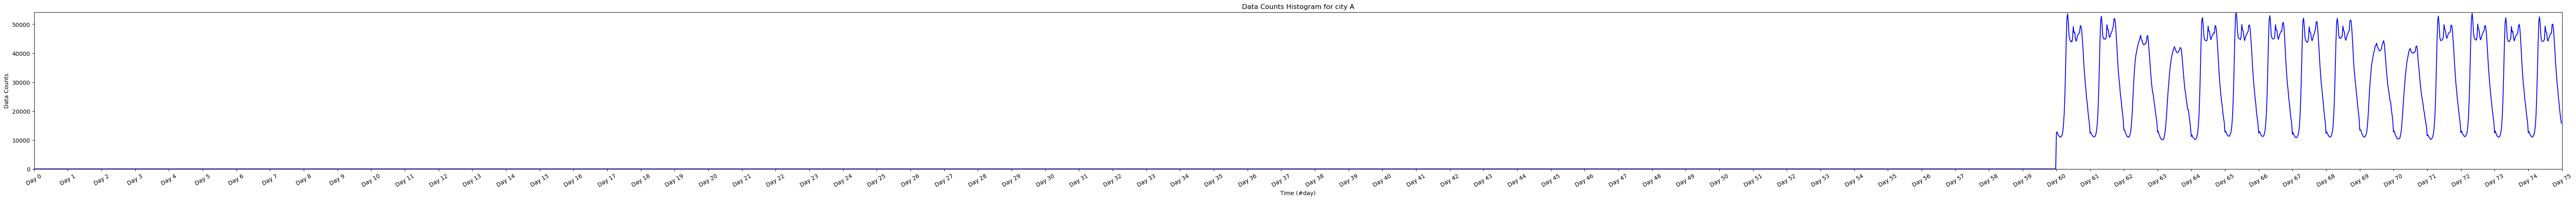

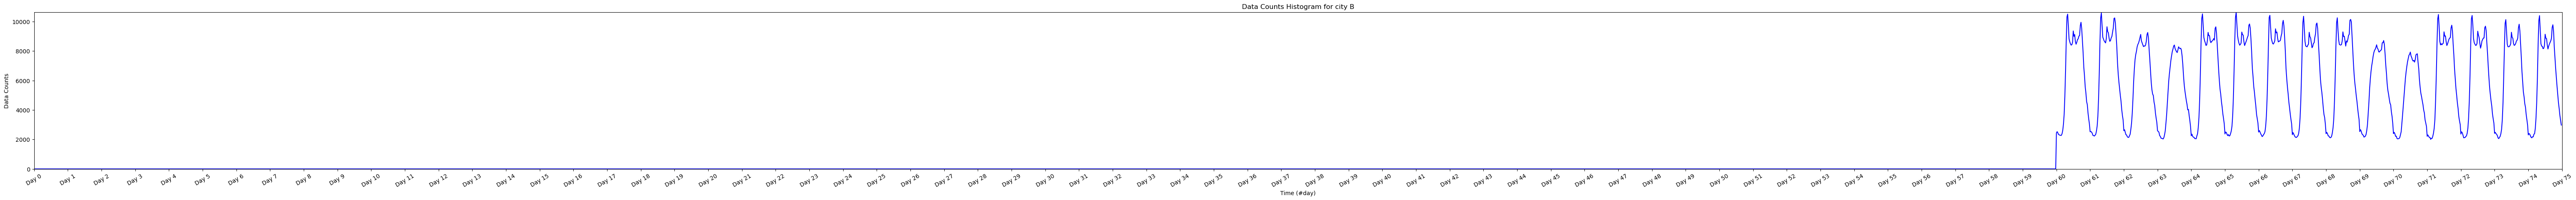

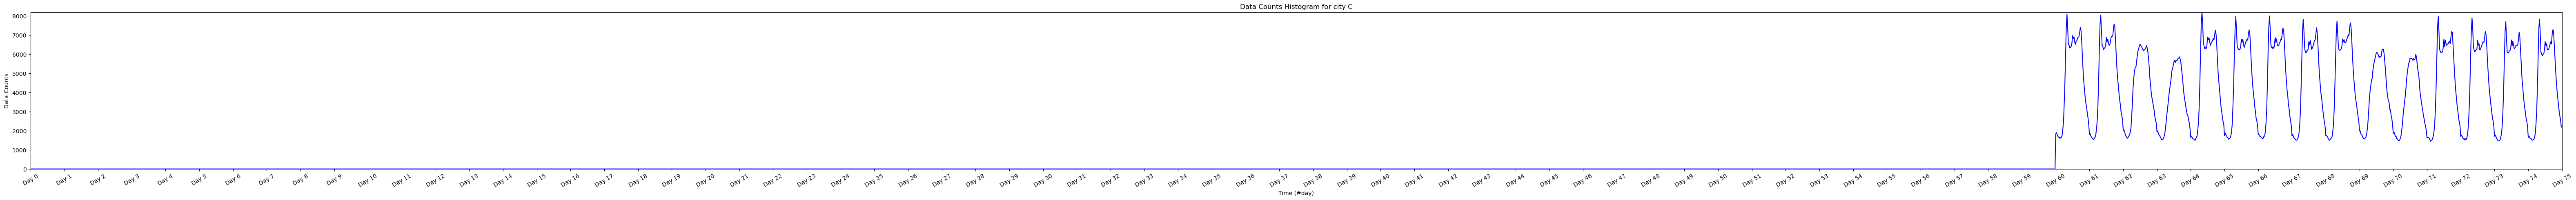

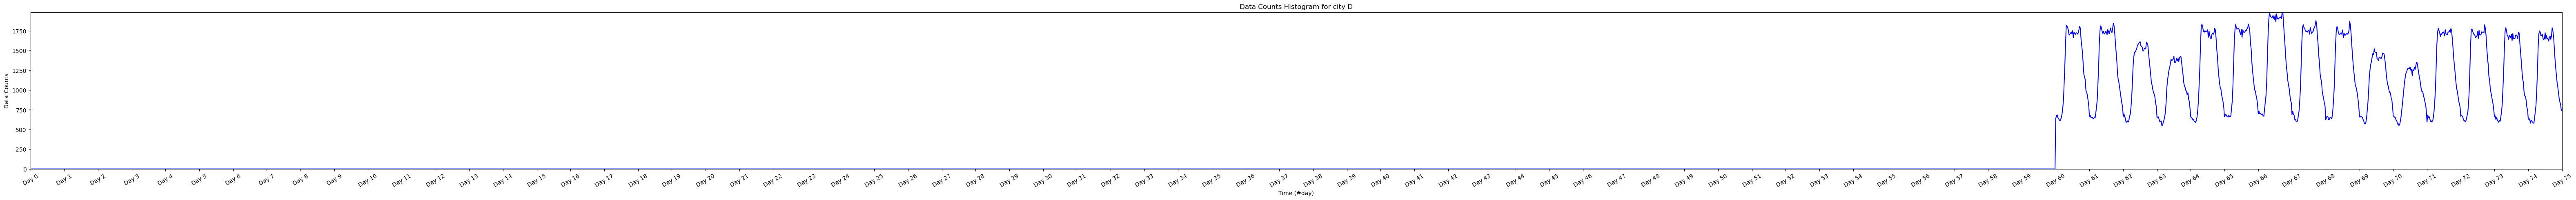

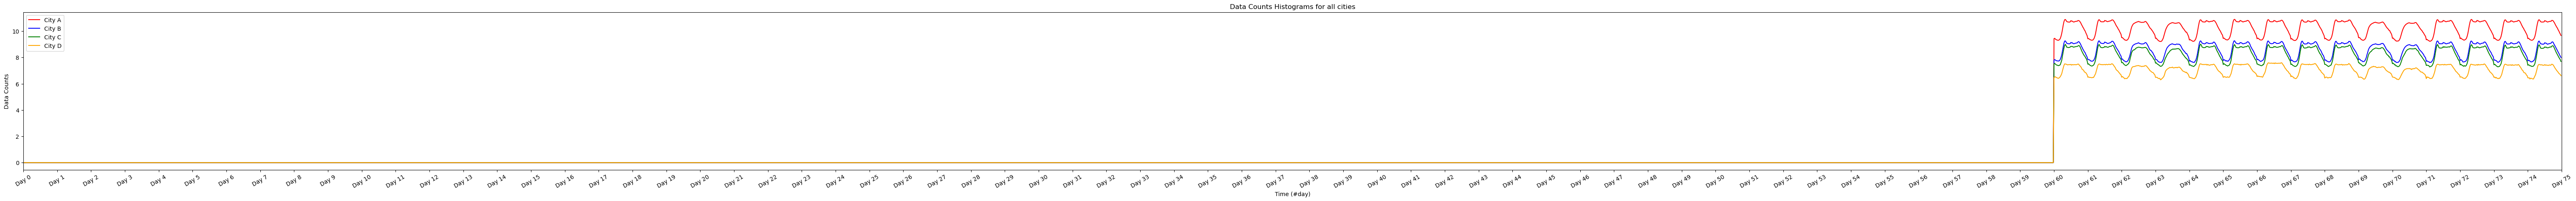

In [177]:
# 绘制待预测区间非预测点的时序图
plot_histogram(data_count_A_np, 'A', 'Data')
plot_histogram(data_count_B_np, 'B', 'Data')
plot_histogram(data_count_C_np, 'C', 'Data')
plot_histogram(data_count_D_np, 'D', 'Data')
plot_histograms(data_count_A_np, data_count_B_np, data_count_C_np, data_count_D_np, type='Data', log=True)

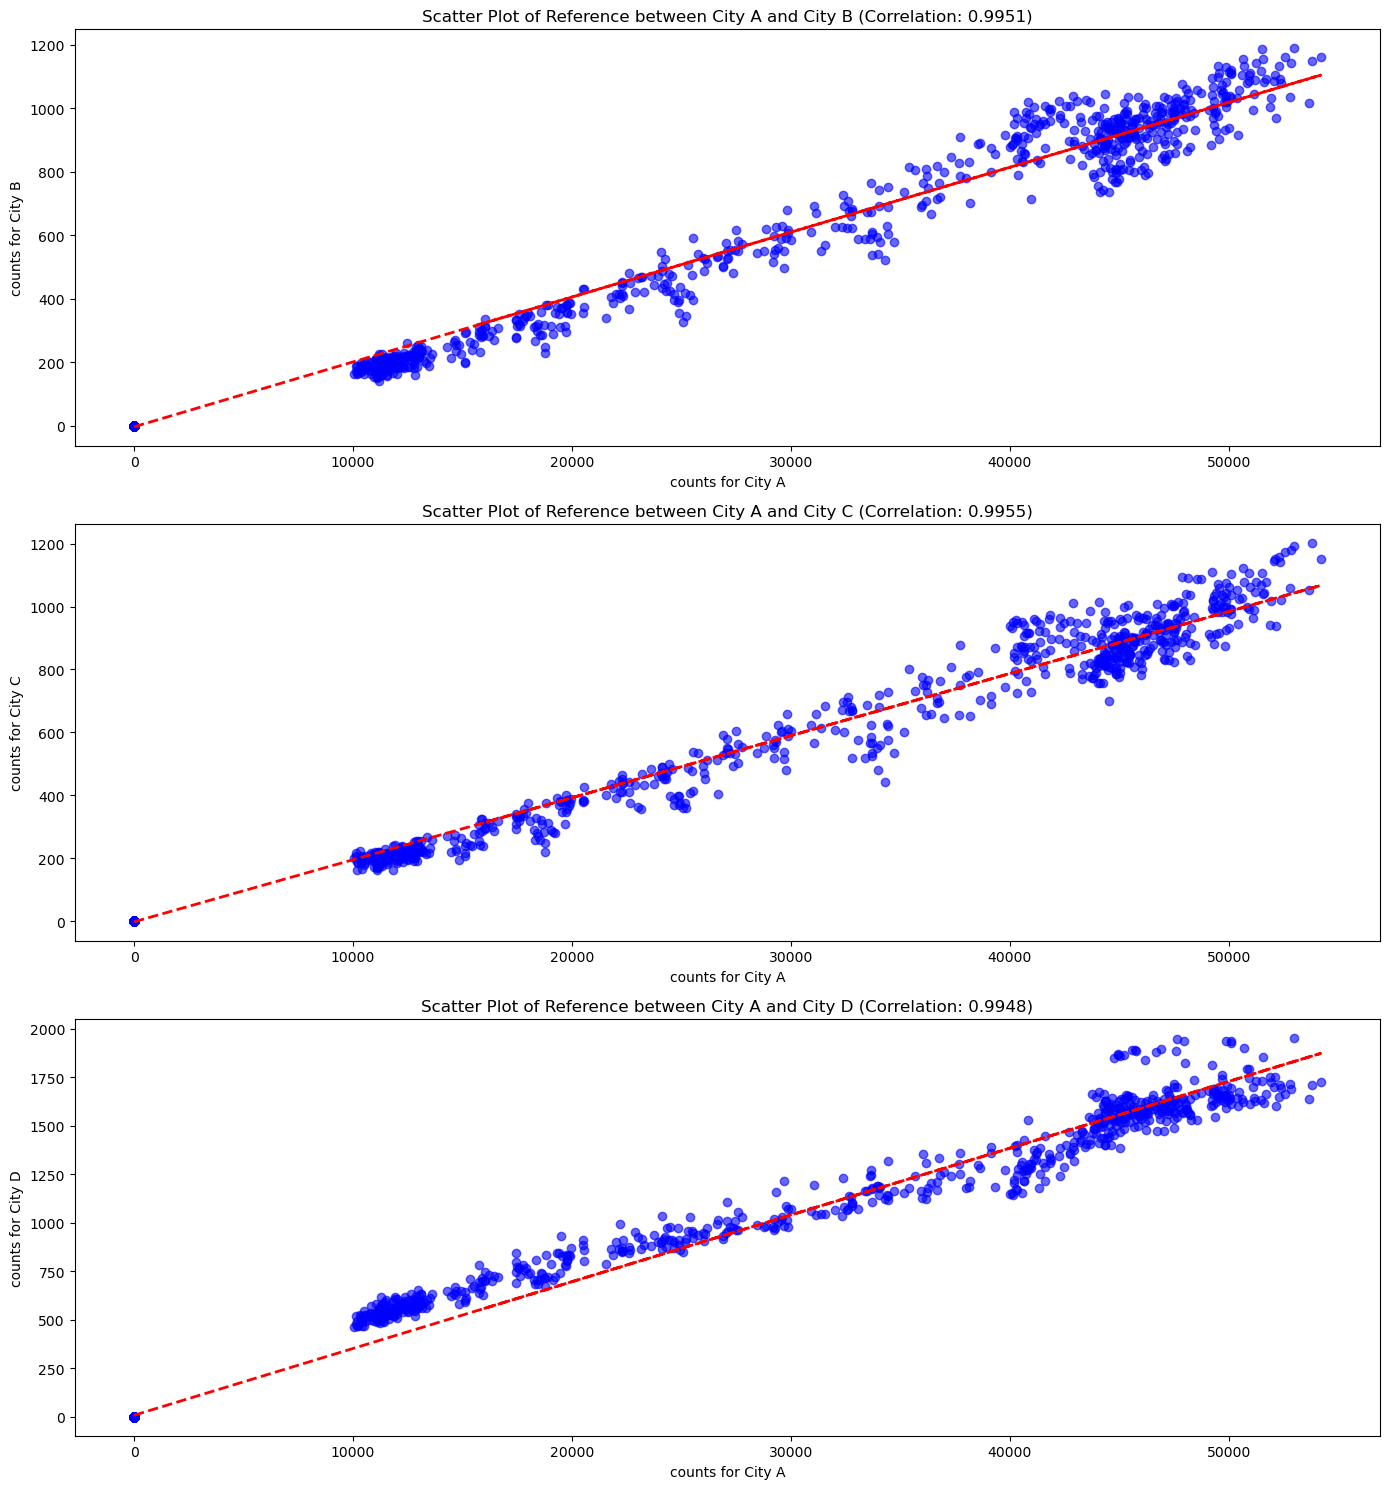

In [178]:
# 城市B,C,D待预测点和城市A待预测区间内点的相关性
plot_multi_scatter(['City A', 'City B', 'City C', 'City D'],data_count_A_np, data_count_B_p, data_count_C_p, data_count_D_p)

## User Activity Move Counts Histogram

In [179]:
# 各城市用户移动活跃度的时序序列
# 1-75天
move_count_A = UAMCH(traj_A)

# 1-60天
move_count_A_rm = UAMCH(traj_A, rm_days=True)
move_count_B_rm = UAMCH(traj_B, rm_days=True)
move_count_C_rm = UAMCH(traj_C, rm_days=True)
move_count_D_rm = UAMCH(traj_D, rm_days=True)

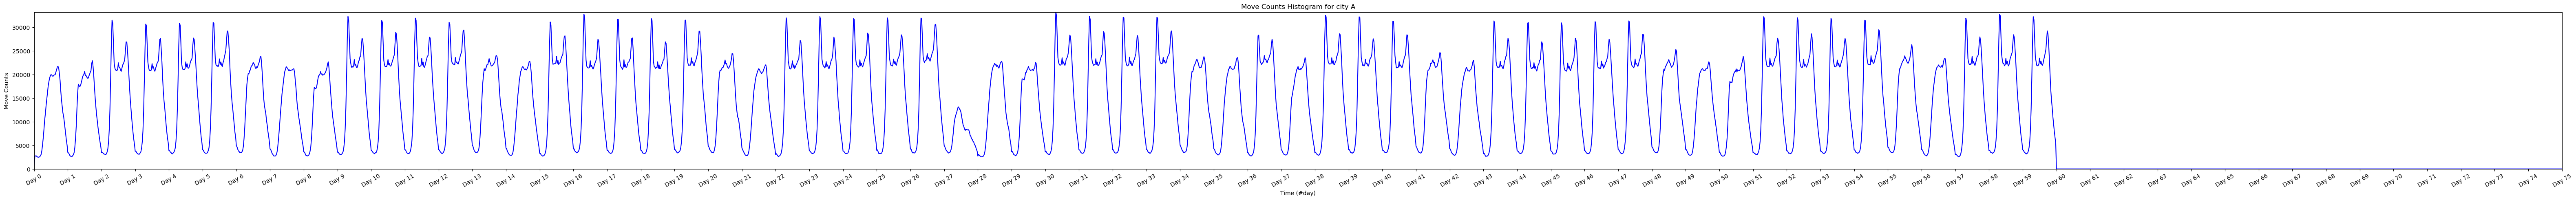

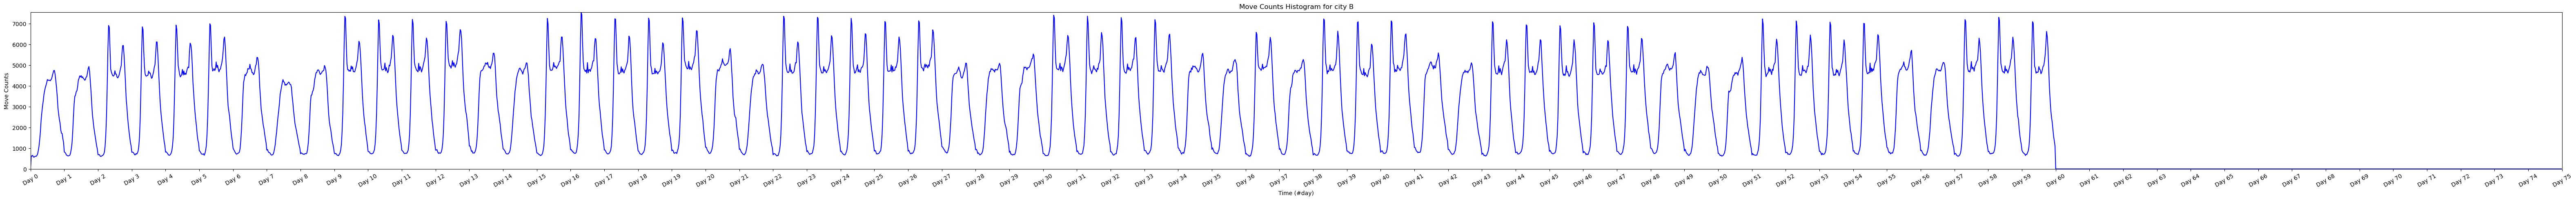

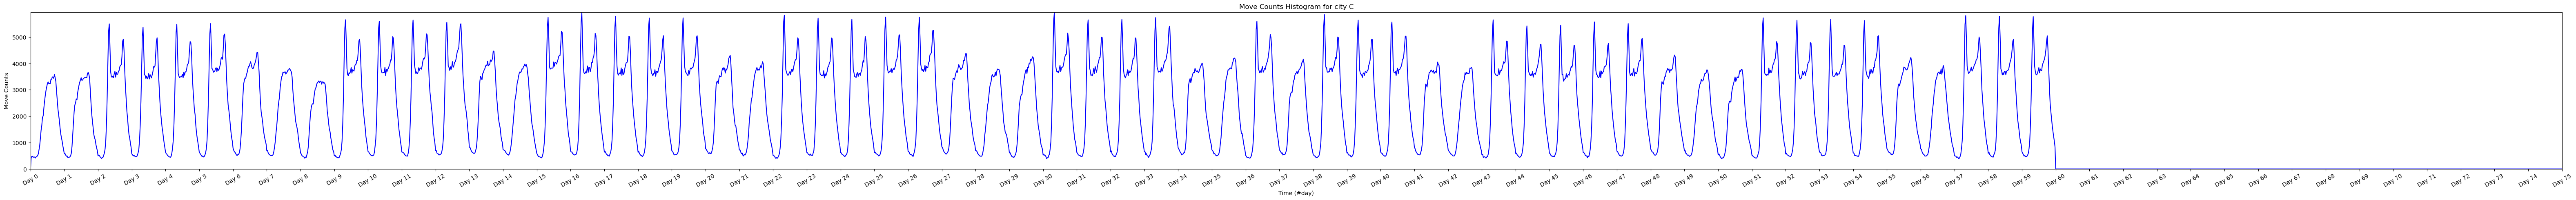

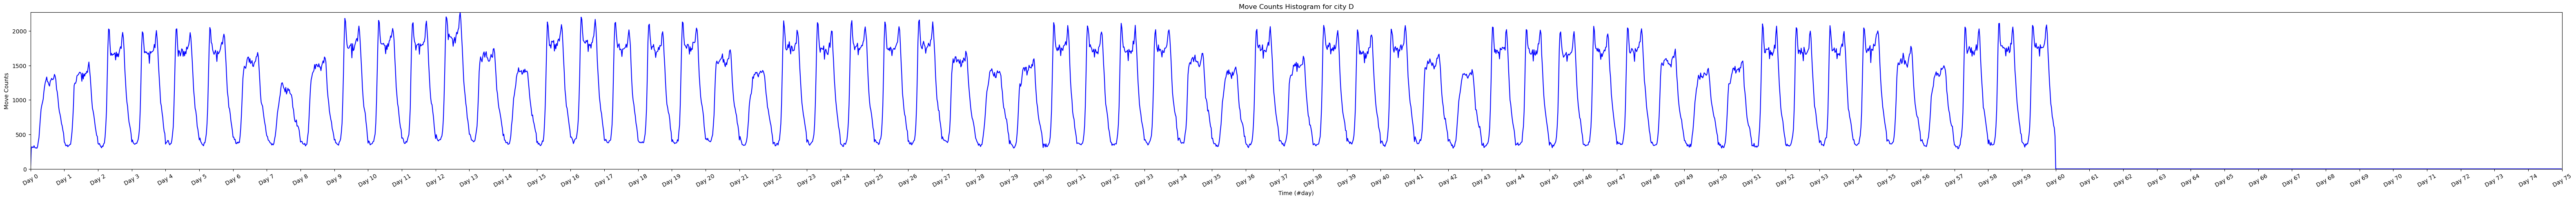

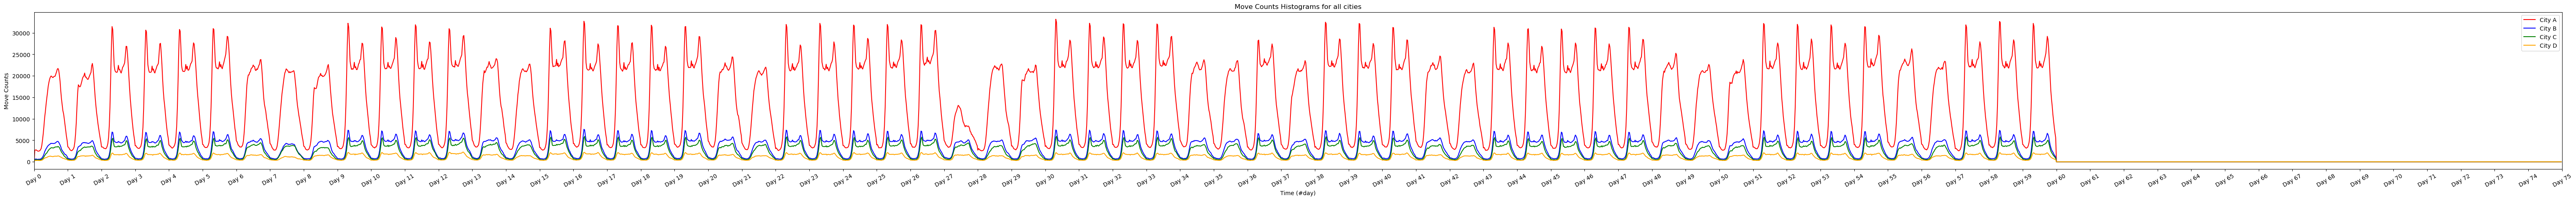

In [180]:
# 绘制各城市用户移动活跃度的时序图
plot_histogram(move_count_A, 'A', 'Move')
plot_histogram(move_count_B_rm, 'B', 'Move')
plot_histogram(move_count_C_rm, 'C', 'Move')
plot_histogram(move_count_D_rm, 'D', 'Move')
plot_histograms(move_count_A, move_count_B_rm, move_count_C_rm, move_count_D_rm, type='Move')

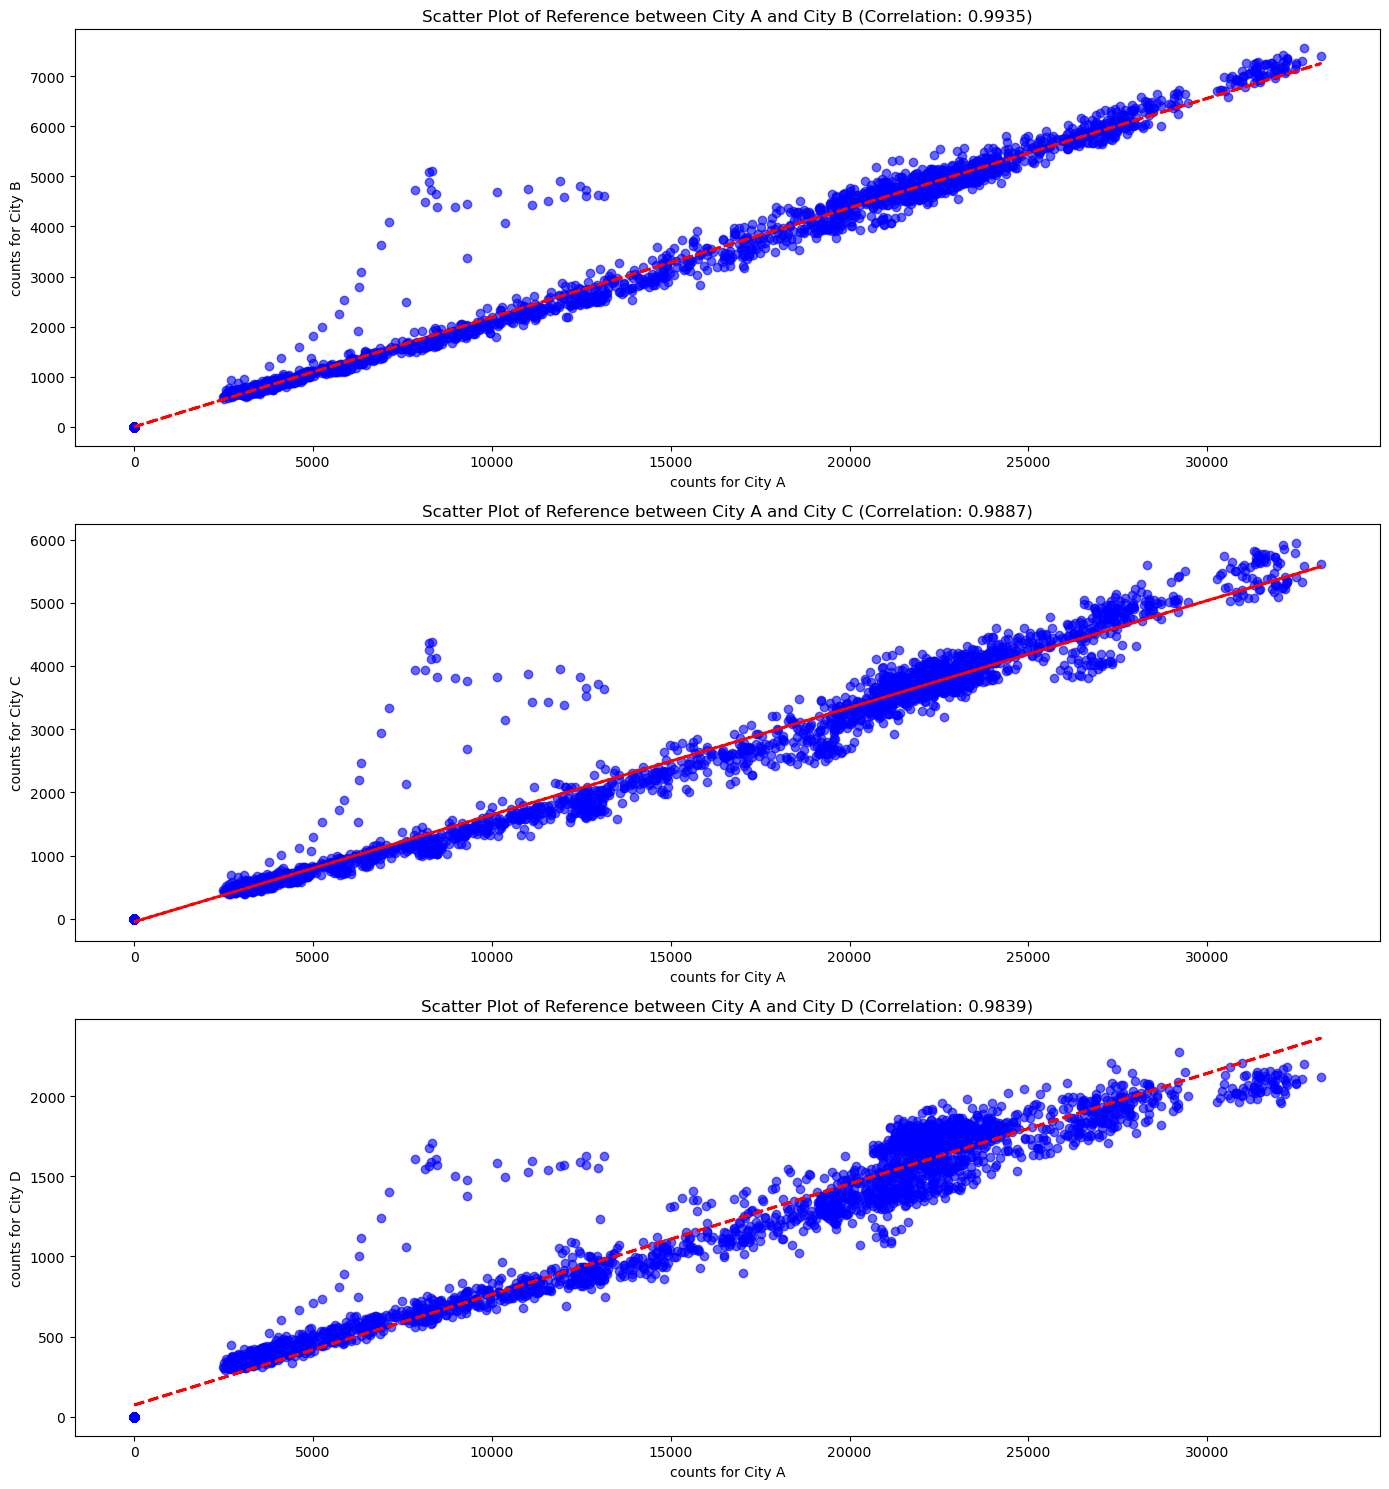

In [181]:
# 相关性分析
plot_multi_scatter(['City A', 'City B', 'City C', 'City D'],move_count_A_rm, move_count_B_rm, move_count_C_rm, move_count_D_rm)

## Corelation between Data counts and Move counts

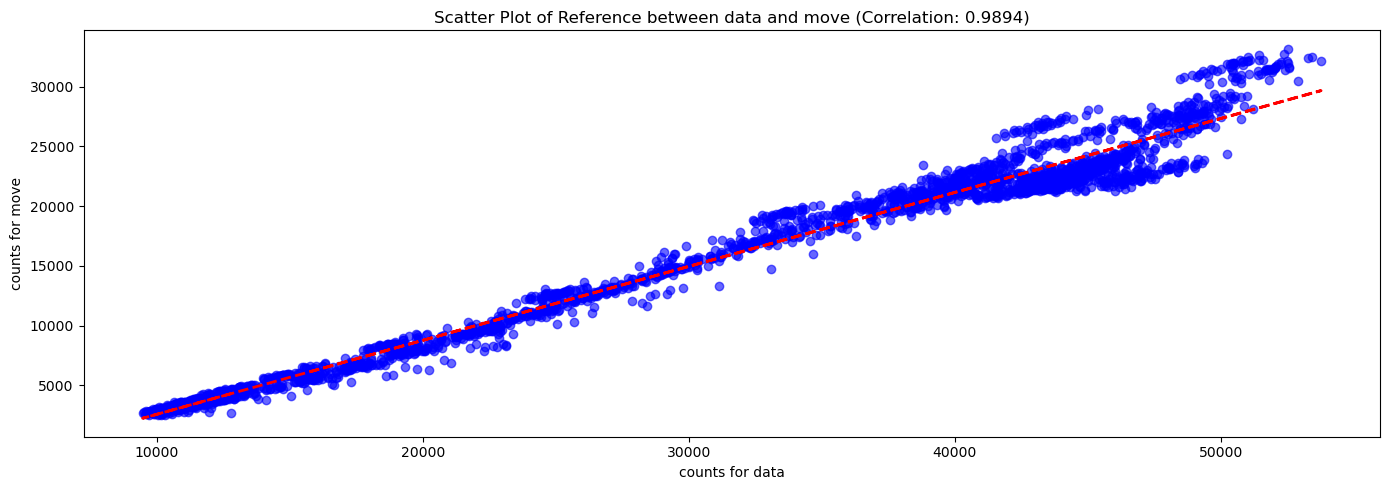

In [182]:
# 签到数和移动数间的相关性分析
mask_m = move_count_A != 0
data_count_A_m, move_count_A_m = data_count_A[mask_m], move_count_A[mask_m]

plot_multi_scatter(['data', 'move'],data_count_A_m, move_count_A_m)

# Spactial Statistics

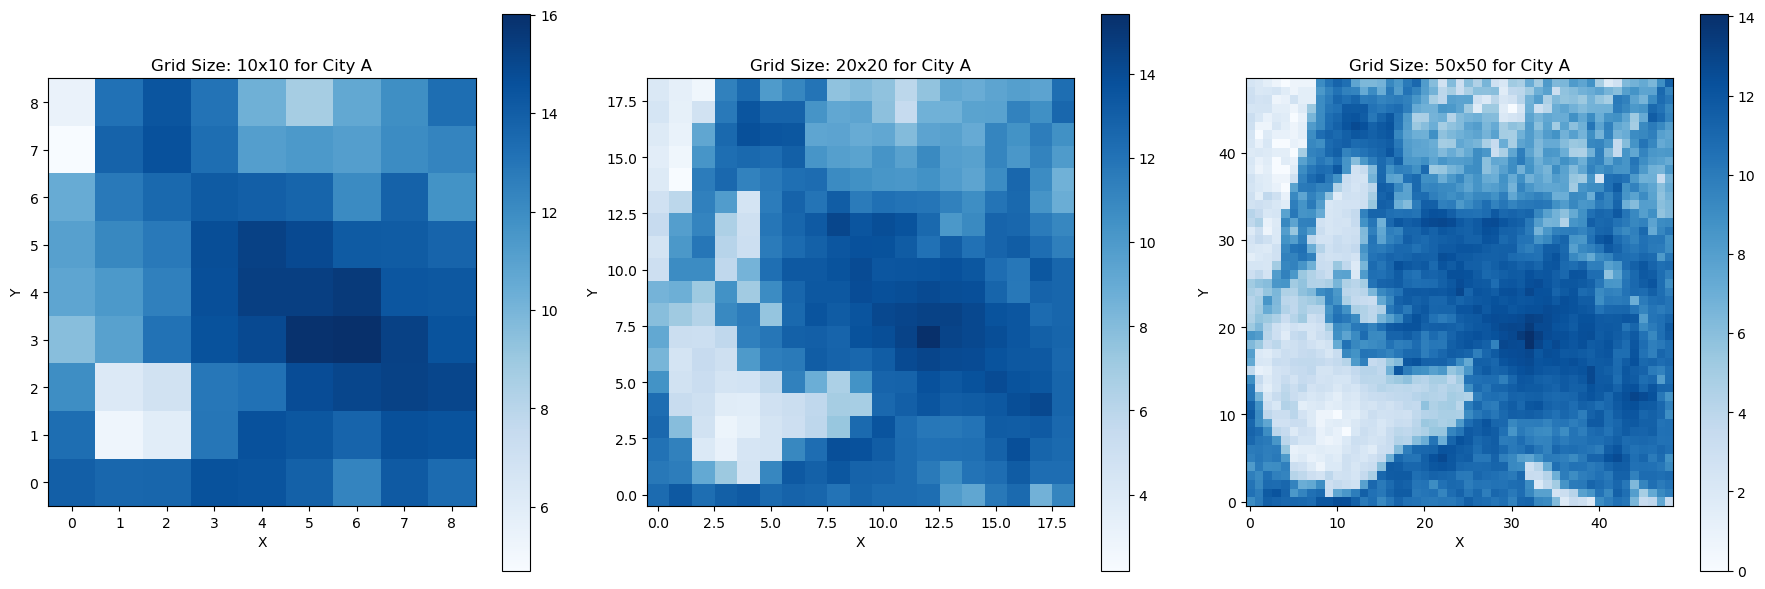

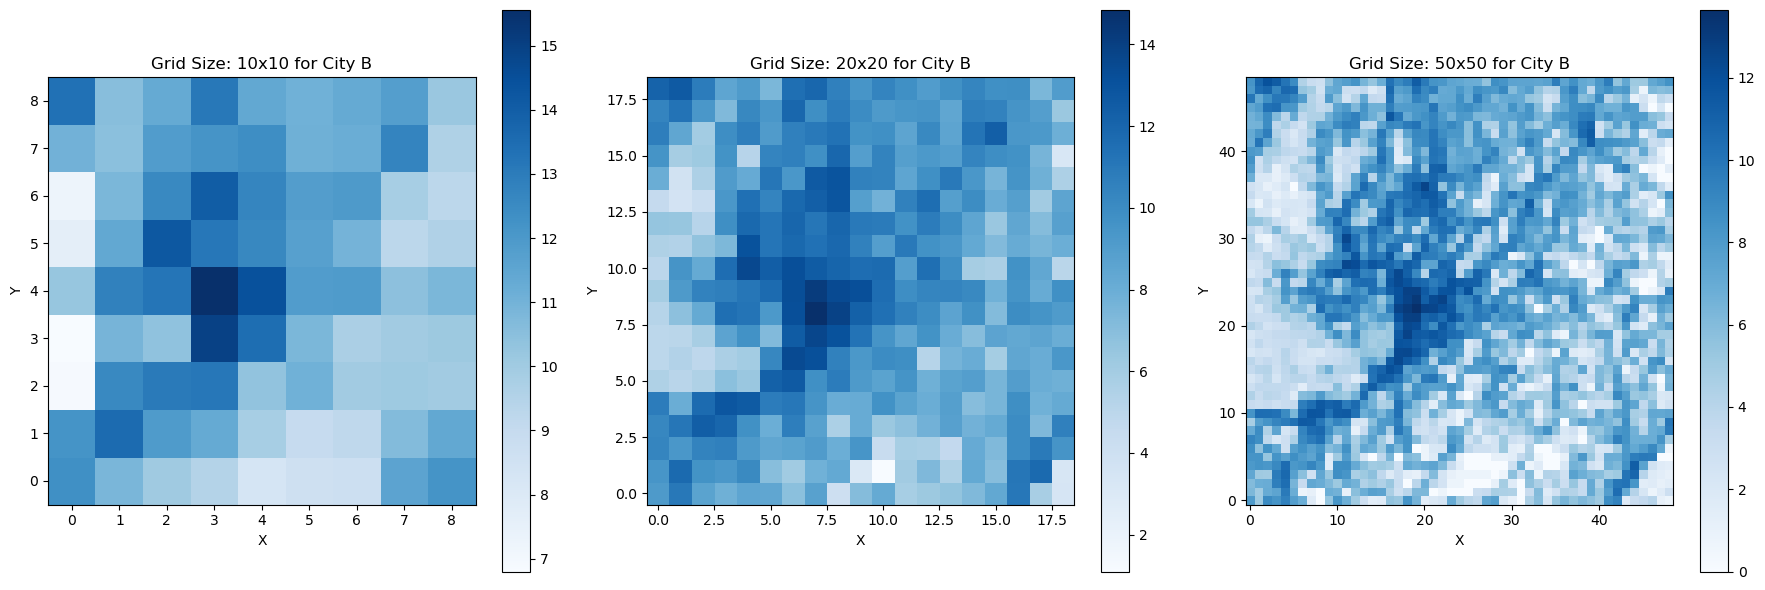

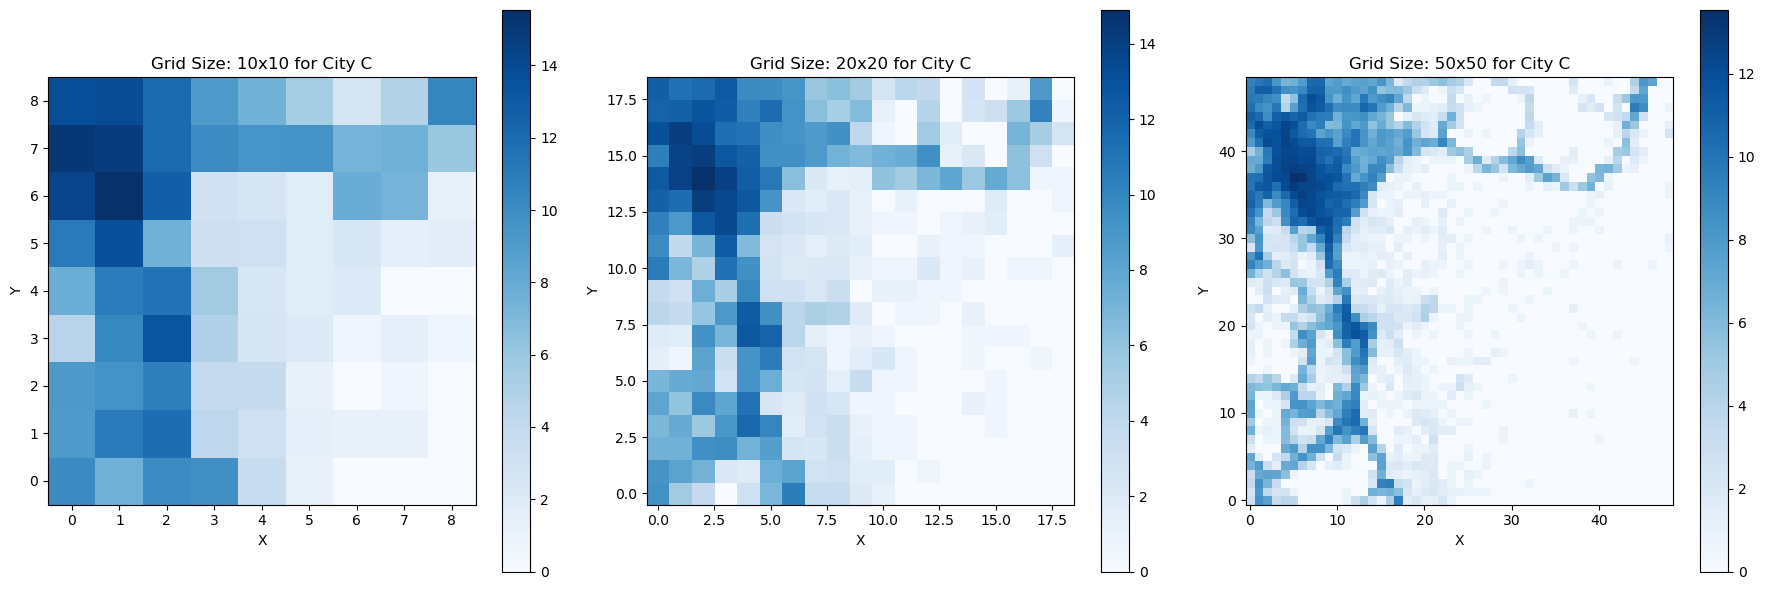

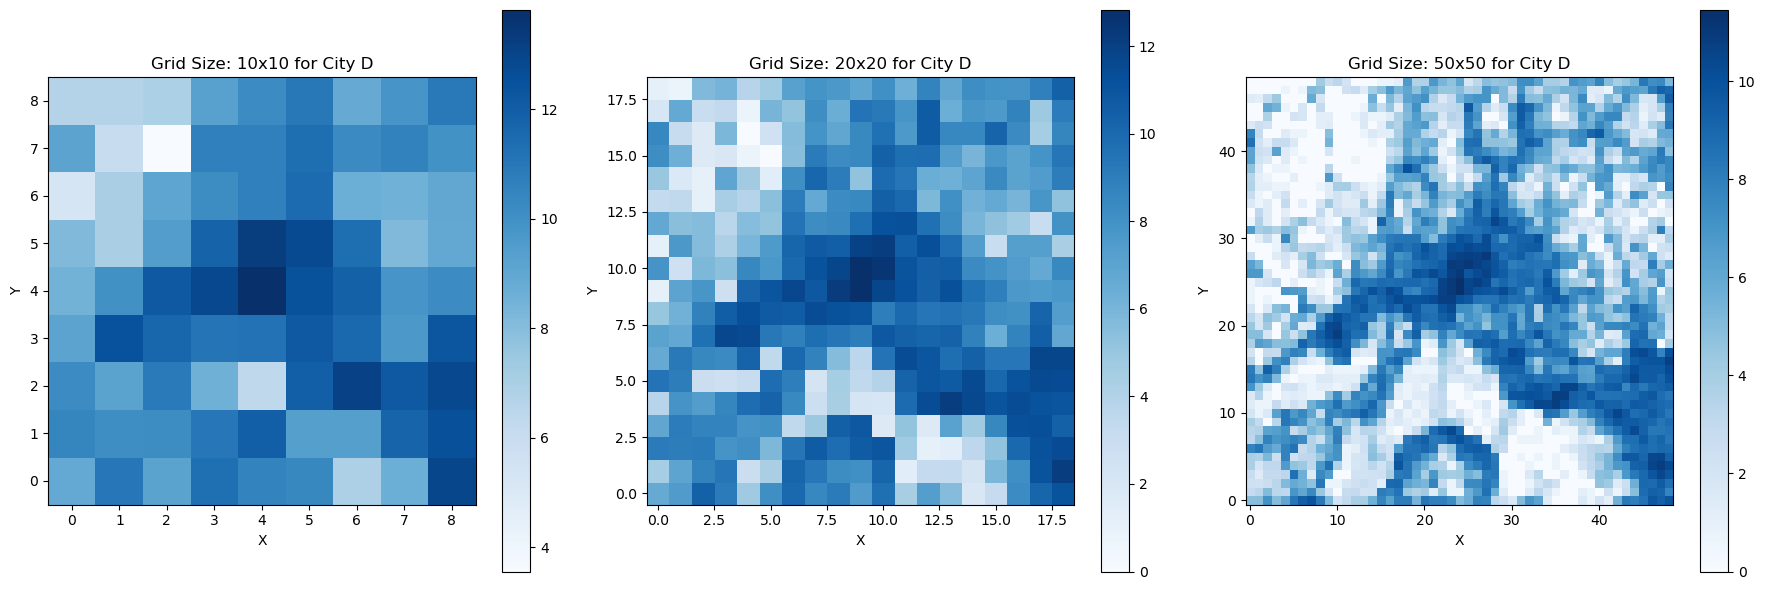

In [185]:
# 绘制各城市不同粒度下的空间分布热力图
plot_coarse_grained_grid_count(traj_A, 'A', log=True)
plot_coarse_grained_grid_count(traj_B, 'B', log=True)
plot_coarse_grained_grid_count(traj_C, 'C', log=True)
plot_coarse_grained_grid_count(traj_D, 'D', log=True)